# freq uncs from legacy sample

In [2]:
#stock imports
import numpy as np
import pandas as pd
import json
import pickle
import scipy
from scipy import constants
import os, sys
from astropy.io import ascii
import astropy.constants
from cmcrameri import cm

##plotting
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from matplotlib.ticker import MaxNLocator
import corner

plt.style.use("Solarize_Light2")
plt.rcParams.update({"axes.edgecolor": "black"})
plt.rcParams.update({"text.color": "black"})
plt.rcParams.update({"axes.labelcolor": "black"})
plt.rcParams.update({"xtick.color": "black"})
plt.rcParams.update({"ytick.color": "black"})
plt.rcParams.update({"font.family": "monospace"})


In [3]:
params = ascii.read("stars/table1.dat", readme = "stars/ReadMe")
params

KIC,Name,Kpmag,numax,Dnu,N,Cat,BkQ,MgQ,Teff,e_Teff,r_Teff,[Fe/H],e_[Fe/H],r_[Fe/H],logg,e_logg,E_logg,Vlos,e_Vlos,vsini,e_vsini
,,mag,uHz,uHz,,,,,K,K,,dex(---),dex(---),,dex(cm / s2),dex(cm / s2),dex(cm / s2),km / s,km / s,km / s,km / s
str8,str9,float64,int64,float64,int64,str6,str8,str18,int64,int64,int64,float64,float64,int64,float64,float64,float64,float64,float64,float64,float64
1435467,--,8.88,1407,70.4,46,F-like,5.1-17.2,--,6326,77,--,0.01,0.1,--,4.1,0.009,0.009,-66.52,0.1,11.9,0.5
2837475,--,8.48,1558,75.7,54,F-like,5.1-17.2,--,6614,77,--,0.01,0.1,--,4.163,0.007,0.007,-13.28,0.1,23.3,0.5
3427720,--,9.11,2737,120.1,36,Simple,5.1-17.2,--,6045,77,--,-0.06,0.1,--,4.387,0.005,0.004,-22.91,0.1,2.9,0.5
3456181,--,9.66,970,52.3,45,F-like,5.1-11.3,"6, 10",6384,77,--,-0.15,0.1,--,3.95,0.007,0.005,-50.12,0.1,8.5,0.5
3632418,Cassie,8.22,1167,60.7,54,F-like,5.1-17.2,--,6193,77,--,-0.12,0.1,--,4.024,0.007,0.005,-19.11,0.1,8.5,0.5
3656476,Java,9.52,1925,93.2,38,Simple,5.1-17.2,"6, 10, 14",5668,77,--,0.25,0.1,--,4.225,0.008,0.01,-13.29,0.1,2.3,0.5
3735871,--,9.71,2863,123.0,34,Simple,5.1-17.2,--,6107,77,--,-0.04,0.1,--,4.396,0.007,0.007,6.9,0.1,4.8,0.5
4914923,Vitto,9.46,1817,88.5,38,Simple,5.1-17.2,6,5805,77,--,0.08,0.1,--,4.197,0.008,0.01,-39.16,0.1,3.4,0.5


In [4]:
freqs = ascii.read("stars/table6.dat", readme = "stars/ReadMe")
freqs = freqs[freqs['l']==0]
freqs

KIC,n,l,Freq,e_Freq,E_Freq,Amp,e_Amp,E_Amp,Width,e_Width,E_Width,l_lnK,lnK
,,,uHz,uHz,uHz,ppm,ppm,ppm,uHz,uHz,uHz,,dex(---)
str8,int64,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,str1,float64
1435467,12,0,928.21507,0.93861,0.71004,2.39354,0.13859,0.13474,4.78553,0.56621,0.96263,--,2.11
1435467,13,0,995.1282,0.42971,0.53104,2.42667,0.17855,0.12309,4.57011,0.7475,0.71635,>,6.0
1435467,14,0,1064.42275,0.3405,0.36169,2.67247,0.17882,0.12735,3.67689,0.53474,0.97238,>,6.0
1435467,15,0,1136.15266,0.33825,0.38756,3.41069,0.14151,0.17474,5.04977,0.70109,1.1473,>,6.0
1435467,16,0,1206.55225,0.20615,0.23525,3.61395,0.14318,0.1563,3.91196,0.59702,0.61436,>,6.0
1435467,17,0,1275.25231,0.29437,0.31292,4.53579,0.15417,0.14946,5.87896,0.62454,0.51971,>,6.0
1435467,18,0,1343.82352,0.35083,0.30581,4.55438,0.1326,0.17259,5.32421,0.5327,0.45294,>,6.0
1435467,19,0,1414.65637,0.17913,0.1869,4.20091,0.11965,0.18534,3.59444,0.3601,0.47502,>,6.0


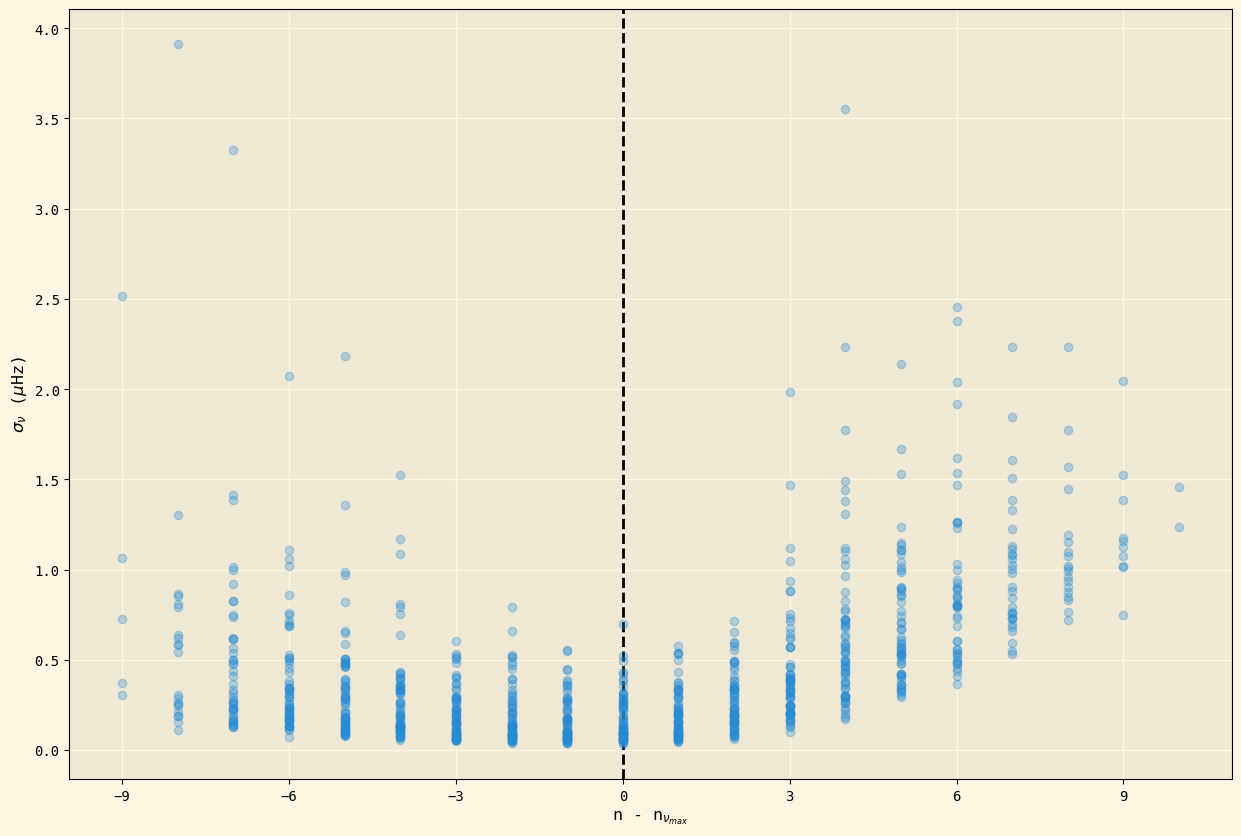

In [5]:
def find_nu_max(params, KIC):
    star = params[params['KIC']==KIC]
    
    return star['numax'].value[0]

def find_nu_max_n(freqs, KIC, nu_max):
    star = freqs[freqs['KIC']==KIC]
    
    star = star[star['l']==0]
    star = star[['n','Freq']]
    
    star['Freq_diff'] = abs(star['Freq'] - nu_max)

    min_diff = min(star['Freq_diff'])

    return star[star['Freq_diff']==min_diff]['n'][0]

params = ascii.read("stars/table1.dat", readme = "stars/ReadMe")
freqs = ascii.read("stars/table6.dat", readme = "stars/ReadMe")

KICs = [KIC for KIC in (params['KIC'])]


fig, ax = plt.subplots(figsize=(15,10))
plt.axvline(0, linestyle='--', c='k', zorder=1)

color = plt.rcParams["axes.prop_cycle"].by_key()["color"][0]
for KIC in KICs:
    nu_max = find_nu_max(params, KIC)
    nu_max_n = find_nu_max_n(freqs, KIC, nu_max)

    star_freqs = freqs[freqs['KIC']==KIC]
    
    star_freqs = star_freqs[star_freqs['l']==0]
    star_freqs = star_freqs[['n','e_Freq','E_Freq']]

    star_freqs['avg_e_Freq'] = (star_freqs['e_Freq'] + star_freqs['E_Freq'])/2

    star_freqs['n_diff'] = star_freqs['n'] - nu_max_n

    plt.scatter(star_freqs['n_diff'],star_freqs['avg_e_Freq'], c=color, alpha=0.3)

ax.set_ylabel(r'$\sigma_{\nu}$ ($\mu$Hz)')
ax.set_xlabel(r'n - n$_{\nu_{max}}$')
ax.xaxis.set_major_locator(MaxNLocator(integer=True))
plt.show()

In [6]:
def find_nu_max(params, KIC):
    star = params[params['KIC']==KIC]
    
    return star['numax'].value[0]

def find_nu_max_n(freqs, KIC, nu_max):
    star = freqs[freqs['KIC']==KIC]
    
    star = star[star['l']==0]
    star = star[['n','Freq']]
    
    star['Freq_diff'] = abs(star['Freq'] - nu_max)

    min_diff = min(star['Freq_diff'])

    return star[star['Freq_diff']==min_diff]['n'][0]

params = ascii.read("stars/table1.dat", readme = "stars/ReadMe")
freqs = ascii.read("stars/table6.dat", readme = "stars/ReadMe")

KICs = [KIC for KIC in (params['KIC'])]

nu_max_errors = []
for KIC in KICs:
    nu_max = find_nu_max(params, KIC)
    nu_max_n = find_nu_max_n(freqs, KIC, nu_max)

    star_freqs = freqs[freqs['KIC']==KIC]
    
    star_freqs = star_freqs[star_freqs['l']==0]
    star_freqs = star_freqs[['n','e_Freq','E_Freq']]

    star_freqs['avg_e_Freq'] = (star_freqs['e_Freq'] + star_freqs['E_Freq'])/2

    star_freqs['n_diff'] = star_freqs['n'] - nu_max_n

    nu_max_error = star_freqs[star_freqs['n_diff']==0]['avg_e_Freq'][0]

    nu_max_errors.append(nu_max_error)
    
print(np.min(nu_max_errors))
print(np.max(nu_max_errors))

0.03289
0.6995800000000001


NameError: name 'freq_error' is not defined

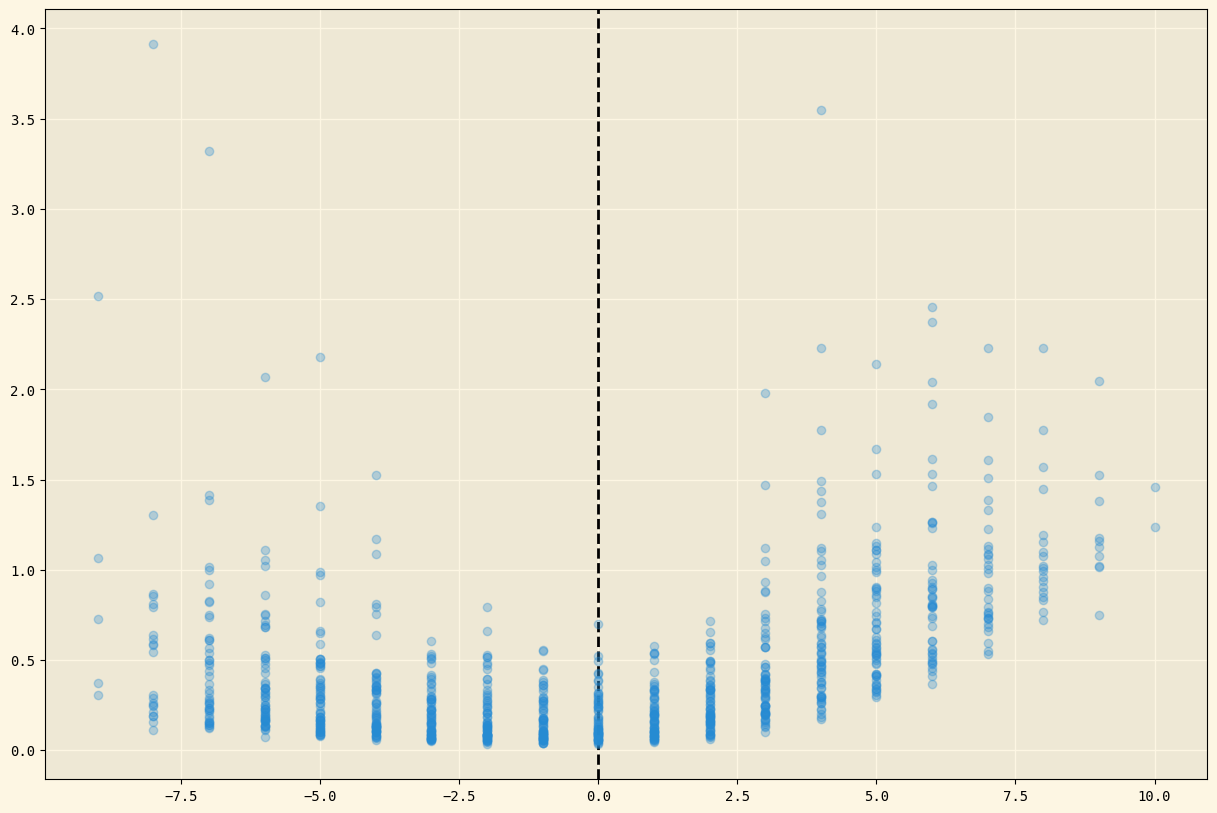

In [7]:
def find_nu_max(params, KIC):
    star = params[params['KIC']==KIC]
    
    return star['numax'].value[0]

def find_nu_max_n(freqs, KIC, nu_max):
    star = freqs[freqs['KIC']==KIC]
    
    star = star[star['l']==0]
    star = star[['n','Freq']]
    
    star['Freq_diff'] = abs(star['Freq'] - nu_max)

    min_diff = min(star['Freq_diff'])

    return star[star['Freq_diff']==min_diff]['n'][0]

params = ascii.read("stars/table1.dat", readme = "stars/ReadMe")
freqs = ascii.read("stars/table6.dat", readme = "stars/ReadMe")

KICs = [KIC for KIC in (params['KIC'])]

n_diffs = []
mean_freq_errors = []

fig, ax = plt.subplots(figsize=(15,10))
plt.axvline(0, linestyle='--', c='k', zorder=1)

colors = plt.rcParams["axes.prop_cycle"].by_key()["color"]
for KIC in KICs:
    nu_max = find_nu_max(params, KIC)
    nu_max_n = find_nu_max_n(freqs, KIC, nu_max)

    star_freqs = freqs[freqs['KIC']==KIC]
    
    star_freqs = star_freqs[star_freqs['l']==0]
    star_freqs = star_freqs[['n','e_Freq','E_Freq']]

    star_freqs['avg_e_Freq'] = (star_freqs['e_Freq'] + star_freqs['E_Freq'])/2

    star_freqs['n_diff'] = star_freqs['n'] - nu_max_n

    plt.scatter(star_freqs['n_diff'],star_freqs['avg_e_Freq'], c=colors[0], alpha=0.3)


for n_diff in range(-9,11):
    n_diffs.append(n_diff)
    
    freq_errors = []
    for KIC in KICs:
        nu_max = find_nu_max(params, KIC)
        nu_max_n = find_nu_max_n(freqs, KIC, nu_max)
    
        star_freqs = freqs[freqs['KIC']==KIC]
        
        star_freqs = star_freqs[star_freqs['l']==0]
        star_freqs = star_freqs[['n','e_Freq','E_Freq']]
    
        star_freqs['avg_e_Freq'] = (star_freqs['e_Freq'] + star_freqs['E_Freq'])/2
    
        star_freqs['n_diff'] = star_freqs['n'] - nu_max_n
        try:
            freq_error = star_freqs[star_freqs['n_diff']==n_diff]['avg_e_Freq'][0]
        except:
            pass

    
        freq_errors.append(freq_error)

    mean_freq_errors.append(np.mean(freq_errors))

plt.scatter(n_diffs, mean_freq_errors, c=colors[0], s=150, marker='X', edgecolor='k', linewidth=1.5)

pos_n_diffs = np.array([i for i in range(0,11)])
plt.plot(pos_n_diffs, 0.17+(0.1*abs(np.array(pos_n_diffs))), c=colors[6])

neg_n_diffs = np.array([i for i in range(-9,1)])
plt.plot(neg_n_diffs, 0.17+(0.05*abs(np.array(neg_n_diffs))), c=colors[6])

ax.set_ylabel(r'$\sigma_{\nu}$ ($\mu$Hz)')
ax.set_xlabel(r'n - n$_{\nu_{max}}$')
ax.xaxis.set_major_locator(MaxNLocator(integer=True))
plt.show()


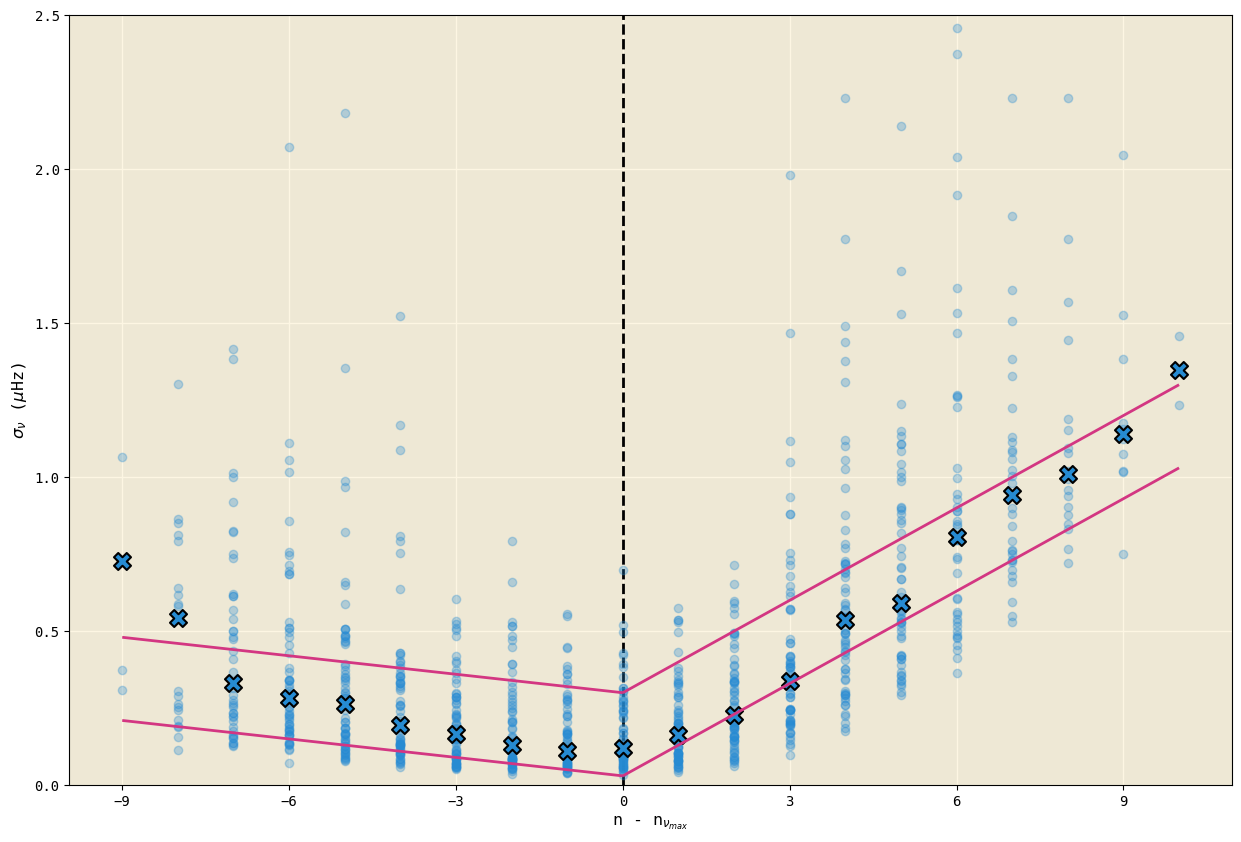

In [9]:
def find_nu_max(params, KIC):
    star = params[params['KIC']==KIC]
    
    return star['numax'].value[0]

def find_nu_max_n(freqs, KIC, nu_max):
    star = freqs[freqs['KIC']==KIC]
    
    star = star[star['l']==0]
    star = star[['n','Freq']]
    
    star['Freq_diff'] = abs(star['Freq'] - nu_max)

    min_diff = min(star['Freq_diff'])

    return star[star['Freq_diff']==min_diff]['n'][0]

params = ascii.read("stars/table1.dat", readme = "stars/ReadMe")
freqs = ascii.read("stars/table6.dat", readme = "stars/ReadMe")


KICs = [KIC for KIC in (params['KIC'])]

n_diffs = []
med_freq_errors = []

fig, ax = plt.subplots(figsize=(15,10))
plt.axvline(0, linestyle='--', c='k', zorder=1)

colors = plt.rcParams["axes.prop_cycle"].by_key()["color"]
for KIC in KICs:
    nu_max = find_nu_max(params, KIC)
    nu_max_n = find_nu_max_n(freqs, KIC, nu_max)

    star_freqs = freqs[freqs['KIC']==KIC]
    
    star_freqs = star_freqs[star_freqs['l']==0]
    star_freqs = star_freqs[['n','e_Freq','E_Freq']]


    star_freqs['avg_e_Freq'] = (star_freqs['e_Freq'] + star_freqs['E_Freq'])/2

    star_freqs['n_diff'] = star_freqs['n'] - nu_max_n

    plt.scatter(star_freqs['n_diff'],star_freqs['avg_e_Freq'], c=colors[0], alpha=0.3)


for n_diff in range(-9,11):
    n_diffs.append(n_diff)
    
    freq_errors = []
    for KIC in KICs:
        nu_max = find_nu_max(params, KIC)
        nu_max_n = find_nu_max_n(freqs, KIC, nu_max)
    
        star_freqs = freqs[freqs['KIC']==KIC]
        
        star_freqs = star_freqs[star_freqs['l']==0]
        star_freqs = star_freqs[['n','e_Freq','E_Freq']]
    
        star_freqs['avg_e_Freq'] = (star_freqs['e_Freq'] + star_freqs['E_Freq'])/2
    
        star_freqs['n_diff'] = star_freqs['n'] - nu_max_n
        try:
            freq_error = star_freqs[star_freqs['n_diff']==n_diff]['avg_e_Freq'][0]
            freq_errors.append(freq_error)
        except:
            pass

    med_freq_errors.append(np.median(freq_errors))

plt.scatter(n_diffs, med_freq_errors, c=colors[0], s=150, marker='X', edgecolor='k', linewidth=1.5)

pos_n_diffs = np.array([i for i in range(0,11)])

nu_max_unc_min = 0.03 
nu_max_unc_max = 0.3

neg_factor = 0.02
pos_factor = 0.1

plt.plot(pos_n_diffs, nu_max_unc_max+(pos_factor*abs(np.array(pos_n_diffs))), c=colors[6])
plt.plot(pos_n_diffs, nu_max_unc_min+(pos_factor*abs(np.array(pos_n_diffs))), c=colors[6])



neg_n_diffs = np.array([i for i in range(-9,1)])
plt.plot(neg_n_diffs, nu_max_unc_max+(neg_factor*abs(np.array(neg_n_diffs))), c=colors[6])
plt.plot(neg_n_diffs, nu_max_unc_min+(neg_factor*abs(np.array(neg_n_diffs))), c=colors[6])


ax.set_ylabel(r'$\sigma_{\nu}$ ($\mu$Hz)')
ax.set_xlabel(r'n - n$_{\nu_{max}}$')
ax.xaxis.set_major_locator(MaxNLocator(integer=True))
ax.set_ylim(ymin = 0, ymax=2.5)
#ax.set_yscale('log')
fig.patch.set_alpha(0)
plt.savefig()